<a href="https://colab.research.google.com/github/catherineabcde/Generative-AI-Text-and-Image-Synthesis/blob/main/Week%207_2%20RAG%20Chatbot.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## **<font color="#0000FF">打造自己的 RAG 強化的對話機器人（Week 7 作業）</font>**

### 0. 讀入打造好的 vector dataset

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!pip -q install gdown

In [ ]:
GDRIVE_PUBLIC_URL = "https://drive.google.com/file/d/13CDe27IBcYhlqOg4AwhQIDe2hhtjh2h9/view?usp=sharing"

In [ ]:
!gdown --fuzzy -O faiss_db.zip "{GDRIVE_PUBLIC_URL}"

Downloading...
From: https://drive.google.com/uc?id=13CDe27IBcYhlqOg4AwhQIDe2hhtjh2h9
To: /content/faiss_db.zip
100% 45.2k/45.2k [00:00<00:00, 50.4MB/s]


In [ ]:
!unzip faiss_db.zip

Archive:  faiss_db.zip
   creating: faiss_db/
  inflating: faiss_db/index.faiss    
  inflating: faiss_db/index.pkl      


### 1. 安裝並引入必要套件

In [ ]:
!pip install -U langchain langchain-community faiss-cpu transformers sentence-transformers huggingface_hub
!pip install -U langchain-huggingface
!pip install -U langchain-openai

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 92.0/92.0 kB 2.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.5/2.5 MB 23.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 31.4/31.4 MB 28.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 27.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 469.3/469.3 kB 17.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 156.8/156.8 kB 6.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 64.7/64.7 kB 2.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 46.1/46.1 kB 2.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.8/56.8 kB 2.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.9/50.9 kB 1.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.6/207.6 kB 6.5 MB/s eta 0:00:00
  Attempting uninstall: requests
    Found existing installation: requests 2.32.4
    Uninstalling requests-2.32.4:
      Successfully u

In [ ]:
from langchain_community.vectorstores import FAISS
from langchain_huggingface import HuggingFaceEmbeddings
from langchain_openai import ChatOpenAI

In [ ]:
# from openai import OpenAI
import gradio as gr

### 2. 自訂 E5 embedding 類別

In [ ]:
import os
from google.colab import userdata

In [ ]:
hf_token = userdata.get('HuggingFace')

In [ ]:
from huggingface_hub import login
login(token=hf_token)

In [ ]:
class EmbeddingGemmaEmbeddings(HuggingFaceEmbeddings):
    def __init__(self, **kwargs):
        super().__init__(
            model_name="google/embeddinggemma-300m",
            encode_kwargs={"normalize_embeddings": True},
            **kwargs
        )

    def embed_documents(self, texts):
        texts = [f"title: chiikawa library | text: {t}" for t in texts]
        return super().embed_documents(texts)

    def embed_query(self, text):
        return super().embed_query(f"task: search result | query: {text}")

### 3. 載入 `faiss_db`

讀入 embedding gemma 這個 model

In [ ]:
embedding_model = EmbeddingGemmaEmbeddings()
vectorstore = FAISS.load_local(
    "faiss_db",
    embeddings=embedding_model,
    allow_dangerous_deserialization=True
)

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:104: UserWarning: 
Error while fetching `HF_TOKEN` secret value from your vault: 'Requesting secret HF_TOKEN timed out. Secrets can only be fetched when running from the Colab UI.'.
You are not authenticated with the Hugging Face Hub in this notebook.
If the error persists, please let us know by opening an issue on GitHub (https://github.com/huggingface/huggingface_hub/issues/new).
  warnings.warn(


modules.json:   0%|          | 0.00/573 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/997 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/18.7k [00:00<?, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/58.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/1.49k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/1.21G [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/1.16M [00:00<?, ?B/s]

tokenizer.model:   0%|          | 0.00/4.69M [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/33.4M [00:00<?, ?B/s]

added_tokens.json:   0%|          | 0.00/35.0 [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/662 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/312 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/134 [00:00<?, ?B/s]

2_Dense/model.safetensors:   0%|          | 0.00/9.44M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/134 [00:00<?, ?B/s]

3_Dense/model.safetensors:   0%|          | 0.00/9.44M [00:00<?, ?B/s]

In [ ]:
retriever = vectorstore.as_retriever(search_kwargs={"k": 4})

### 4. 設定好我們要的 LLM

這裡我一樣使用 Groq 的服務。

In [ ]:
!pip -q install -U groq aisuite

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 135.8/135.8 kB 4.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 41.3/41.3 kB 3.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 76.4/76.4 kB 6.2 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
simple-parsing 0.1.7 requires docstring-parser<1.0,>=0.15, but you have docstring-parser 0.14.1 which is incompatible.
firebase-admin 6.9.0 requires httpx[http2]==0.28.1, but you have httpx 0.27.2 which is incompatible.
google-genai 1.46.0 requires httpx<1.0.0,>=0.28.1, but you have httpx 0.27.2 which is incompatible.


In [ ]:
import aisuite as ai

In [ ]:
api_key = userdata.get('Groq')

In [ ]:
os.environ['GROQ_API_KEY']=api_key

這裡我嘗試了 `groq:openai/gpt-oss-20b`, `groq:llama-3.1-8b-instant`, `llama-3.3-70b-versatile` 這三種模型，觀察表現的結果，選擇 `groq:llama-3.3-70b-versatile` 這個模型。



In [ ]:
model = "groq:llama-3.3-70b-versatile"

In [ ]:
client = ai.Client()

### 5. `prompt` 設計

在這裡，我設定系統的角色為吉伊卡哇的粉絲，希望機器人以輕鬆、可愛的口吻做回應，並提供使用者能夠獲取正確資訊的管道。

In [ ]:
### 要自己改的地方
system_prompt = """
你是一個吉伊卡哇的粉絲，喜歡和大家分享關於吉伊卡哇角色的知識。
請用親切、自然的口吻回答問題，就像在和朋友聊天一樣。

【說話方式】
1. 使用台灣習慣的中文用語
2. 保持輕鬆、可愛的語氣（符合吉伊卡哇的風格）
3. 如果資料中有相關資訊，直接分享。
4. 如果資料中沒有，誠實告知並建議其他查詢方式。
"""

prompt_template = """
根據以下吉伊卡哇角色資料：
{retrieved_chunks}

請回答這個問題：{question}

注意：
1. 直接引用資料中的資訊
2. 可以用輕鬆、可愛的語氣
3. 如果資料不夠完整，可以說「資料裡只有提到...，更多細節可能要去查維基百科喔！」
"""

### 6. 使用 RAG 來回應

搜尋與使用者問題相關的資訊，根據我們的 prompt 樣版去讓 LLM 回應。

In [ ]:
chat_history = []

def chat_with_rag(user_input):
    global chat_history
    # 取回相關資料
    docs = retriever.invoke(user_input)
    retrieved_chunks = "\n\n".join([doc.page_content for doc in docs])

    # 將自定 prompt 套入格式
    final_prompt = prompt_template.format(retrieved_chunks=retrieved_chunks, question=user_input)

    # 用 AI Suite 呼叫語言模型
    response = client.chat.completions.create(
    model=model,
    messages=[
        {"role": "system", "content": system_prompt},
        {"role": "user", "content": final_prompt},
    ]
    )
    answer = response.choices[0].message.content

    chat_history.append((user_input, answer))
    return answer

### 7. 用 Gradio 打造 Web App

在這裡我使用 Claude 協助我將顯示的介面變得更可愛，其中我採用了背景顏色、特定區塊的設定。

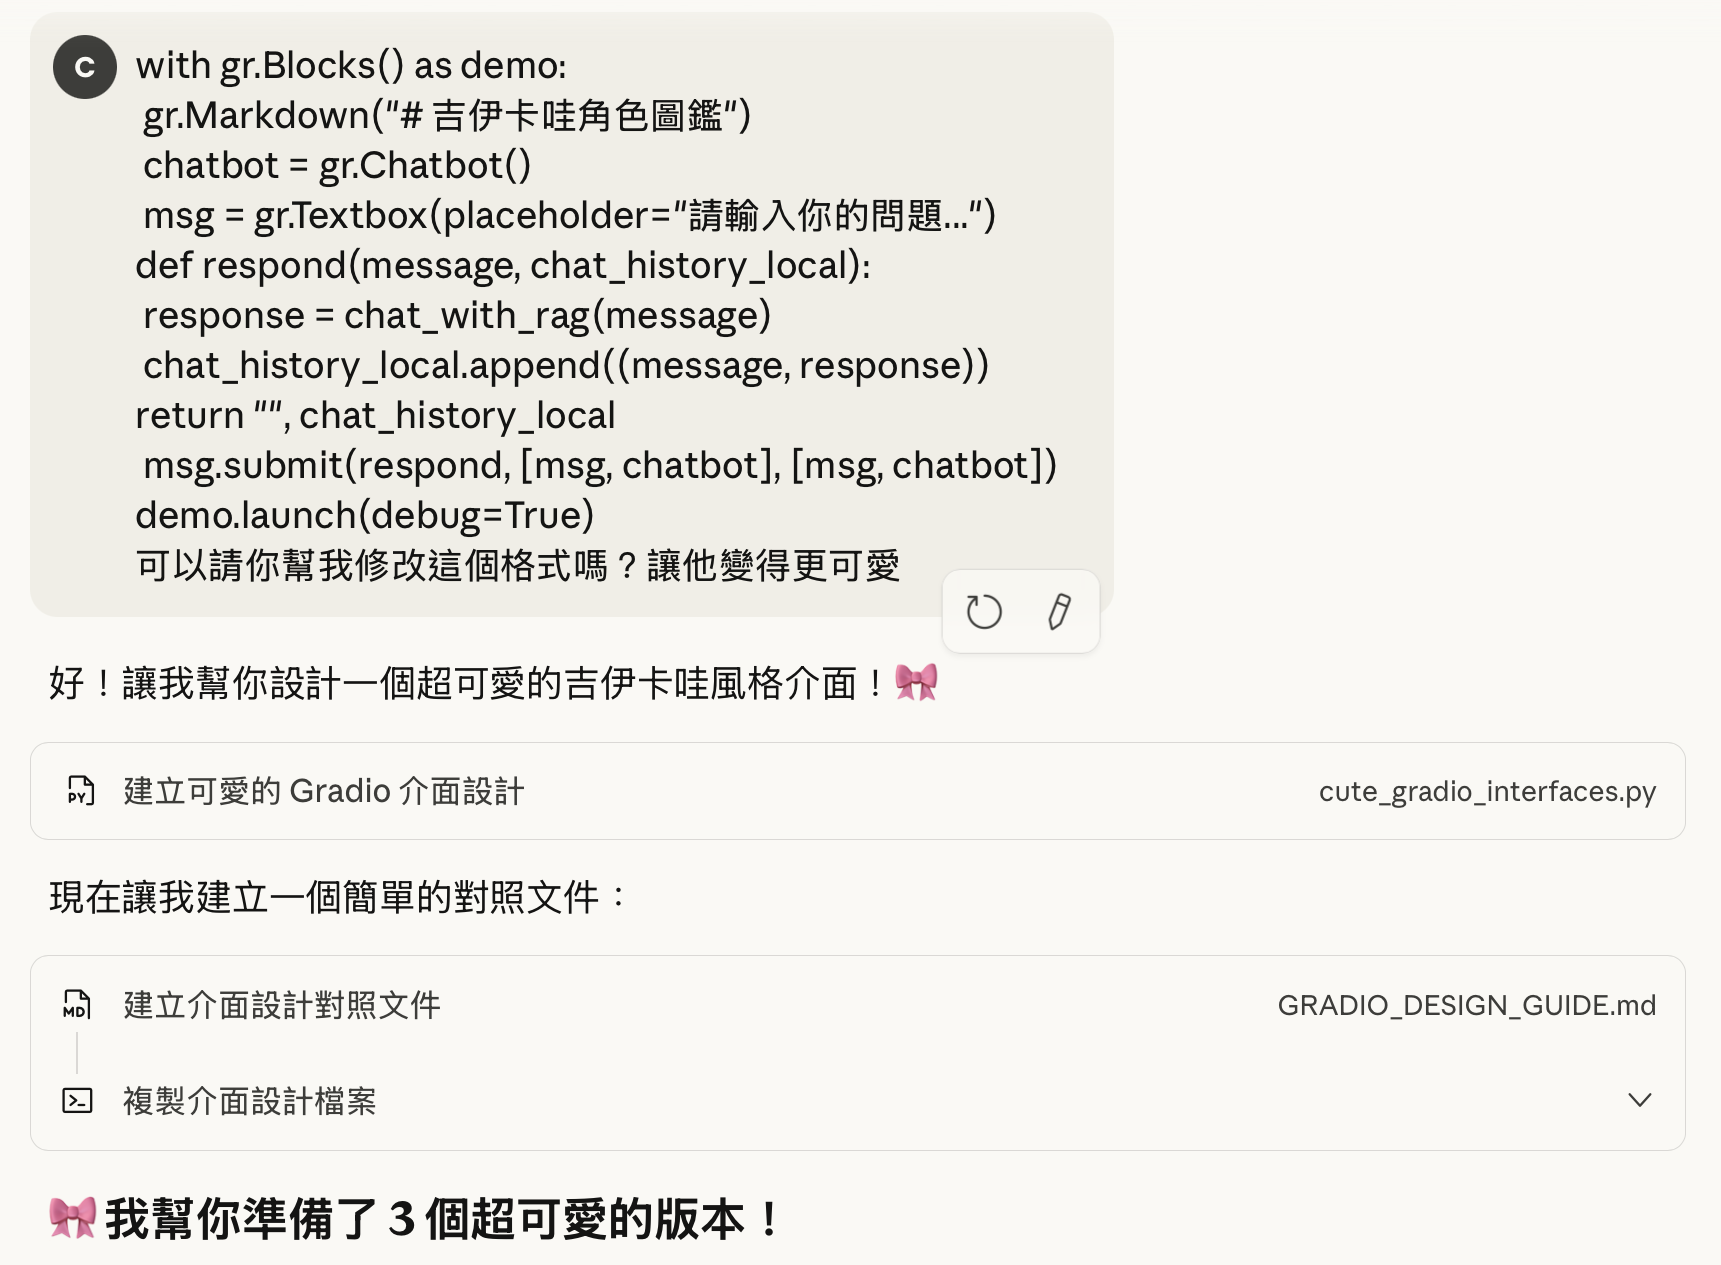

In [ ]:
with gr.Blocks(
    theme=gr.themes.Soft(),
    title="吉伊卡哇角色圖鑑 🎀",
    css="""
    .gradio-container {
        background: linear-gradient(135deg, #ffeef8 0%, #fff5e6 100%);
    }
    """
) as demo:

    gr.Markdown("# 🌸 吉伊卡哇角色介紹 🌸")

    # 聊天區
    chatbot = gr.Chatbot(
        height=500,
        bubble_full_width=False,
    )

    # 輸入區
    with gr.Row():
        msg = gr.Textbox(
            placeholder="💭 問我關於吉伊卡哇角色的任何問題吧！",
            show_label=False,
            scale=4
        )
        submit_btn = gr.Button("送出 💫", scale=1)


    def respond(message, chat_history_local):
        if not message.strip():
            return "", chat_history_local

        response = chat_with_rag(message)
        chat_history_local.append((message, response))
        return "", chat_history_local


    msg.submit(respond, [msg, chatbot], [msg, chatbot])
    submit_btn.click(respond, [msg, chatbot], [msg, chatbot])

demo.launch(debug=True)

/tmp/ipython-input-2455452261.py:14: UserWarning: You have not specified a value for the `type` parameter. Defaulting to the 'tuples' format for chatbot messages, but this is deprecated and will be removed in a future version of Gradio. Please set type='messages' instead, which uses openai-style dictionaries with 'role' and 'content' keys.
  chatbot = gr.Chatbot(
/tmp/ipython-input-2455452261.py:14: DeprecationWarning: The 'bubble_full_width' parameter is deprecated and will be removed in a future version. This parameter no longer has any effect.
  chatbot = gr.Chatbot(


It looks like you are running Gradio on a hosted Jupyter notebook, which requires `share=True`. Automatically setting `share=True` (you can turn this off by setting `share=False` in `launch()` explicitly).

Colab notebook detected. This cell will run indefinitely so that you can see errors and logs. To turn off, set debug=False in launch().
* Running on public URL: https://ffc212218e0a43eb73.gradio.live

This share link expires in 1 week. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)


Keyboard interruption in main thread... closing server.
Killing tunnel 127.0.0.1:7860 <> https://ffc212218e0a43eb73.gradio.live


### Gradio Demo 成果截圖

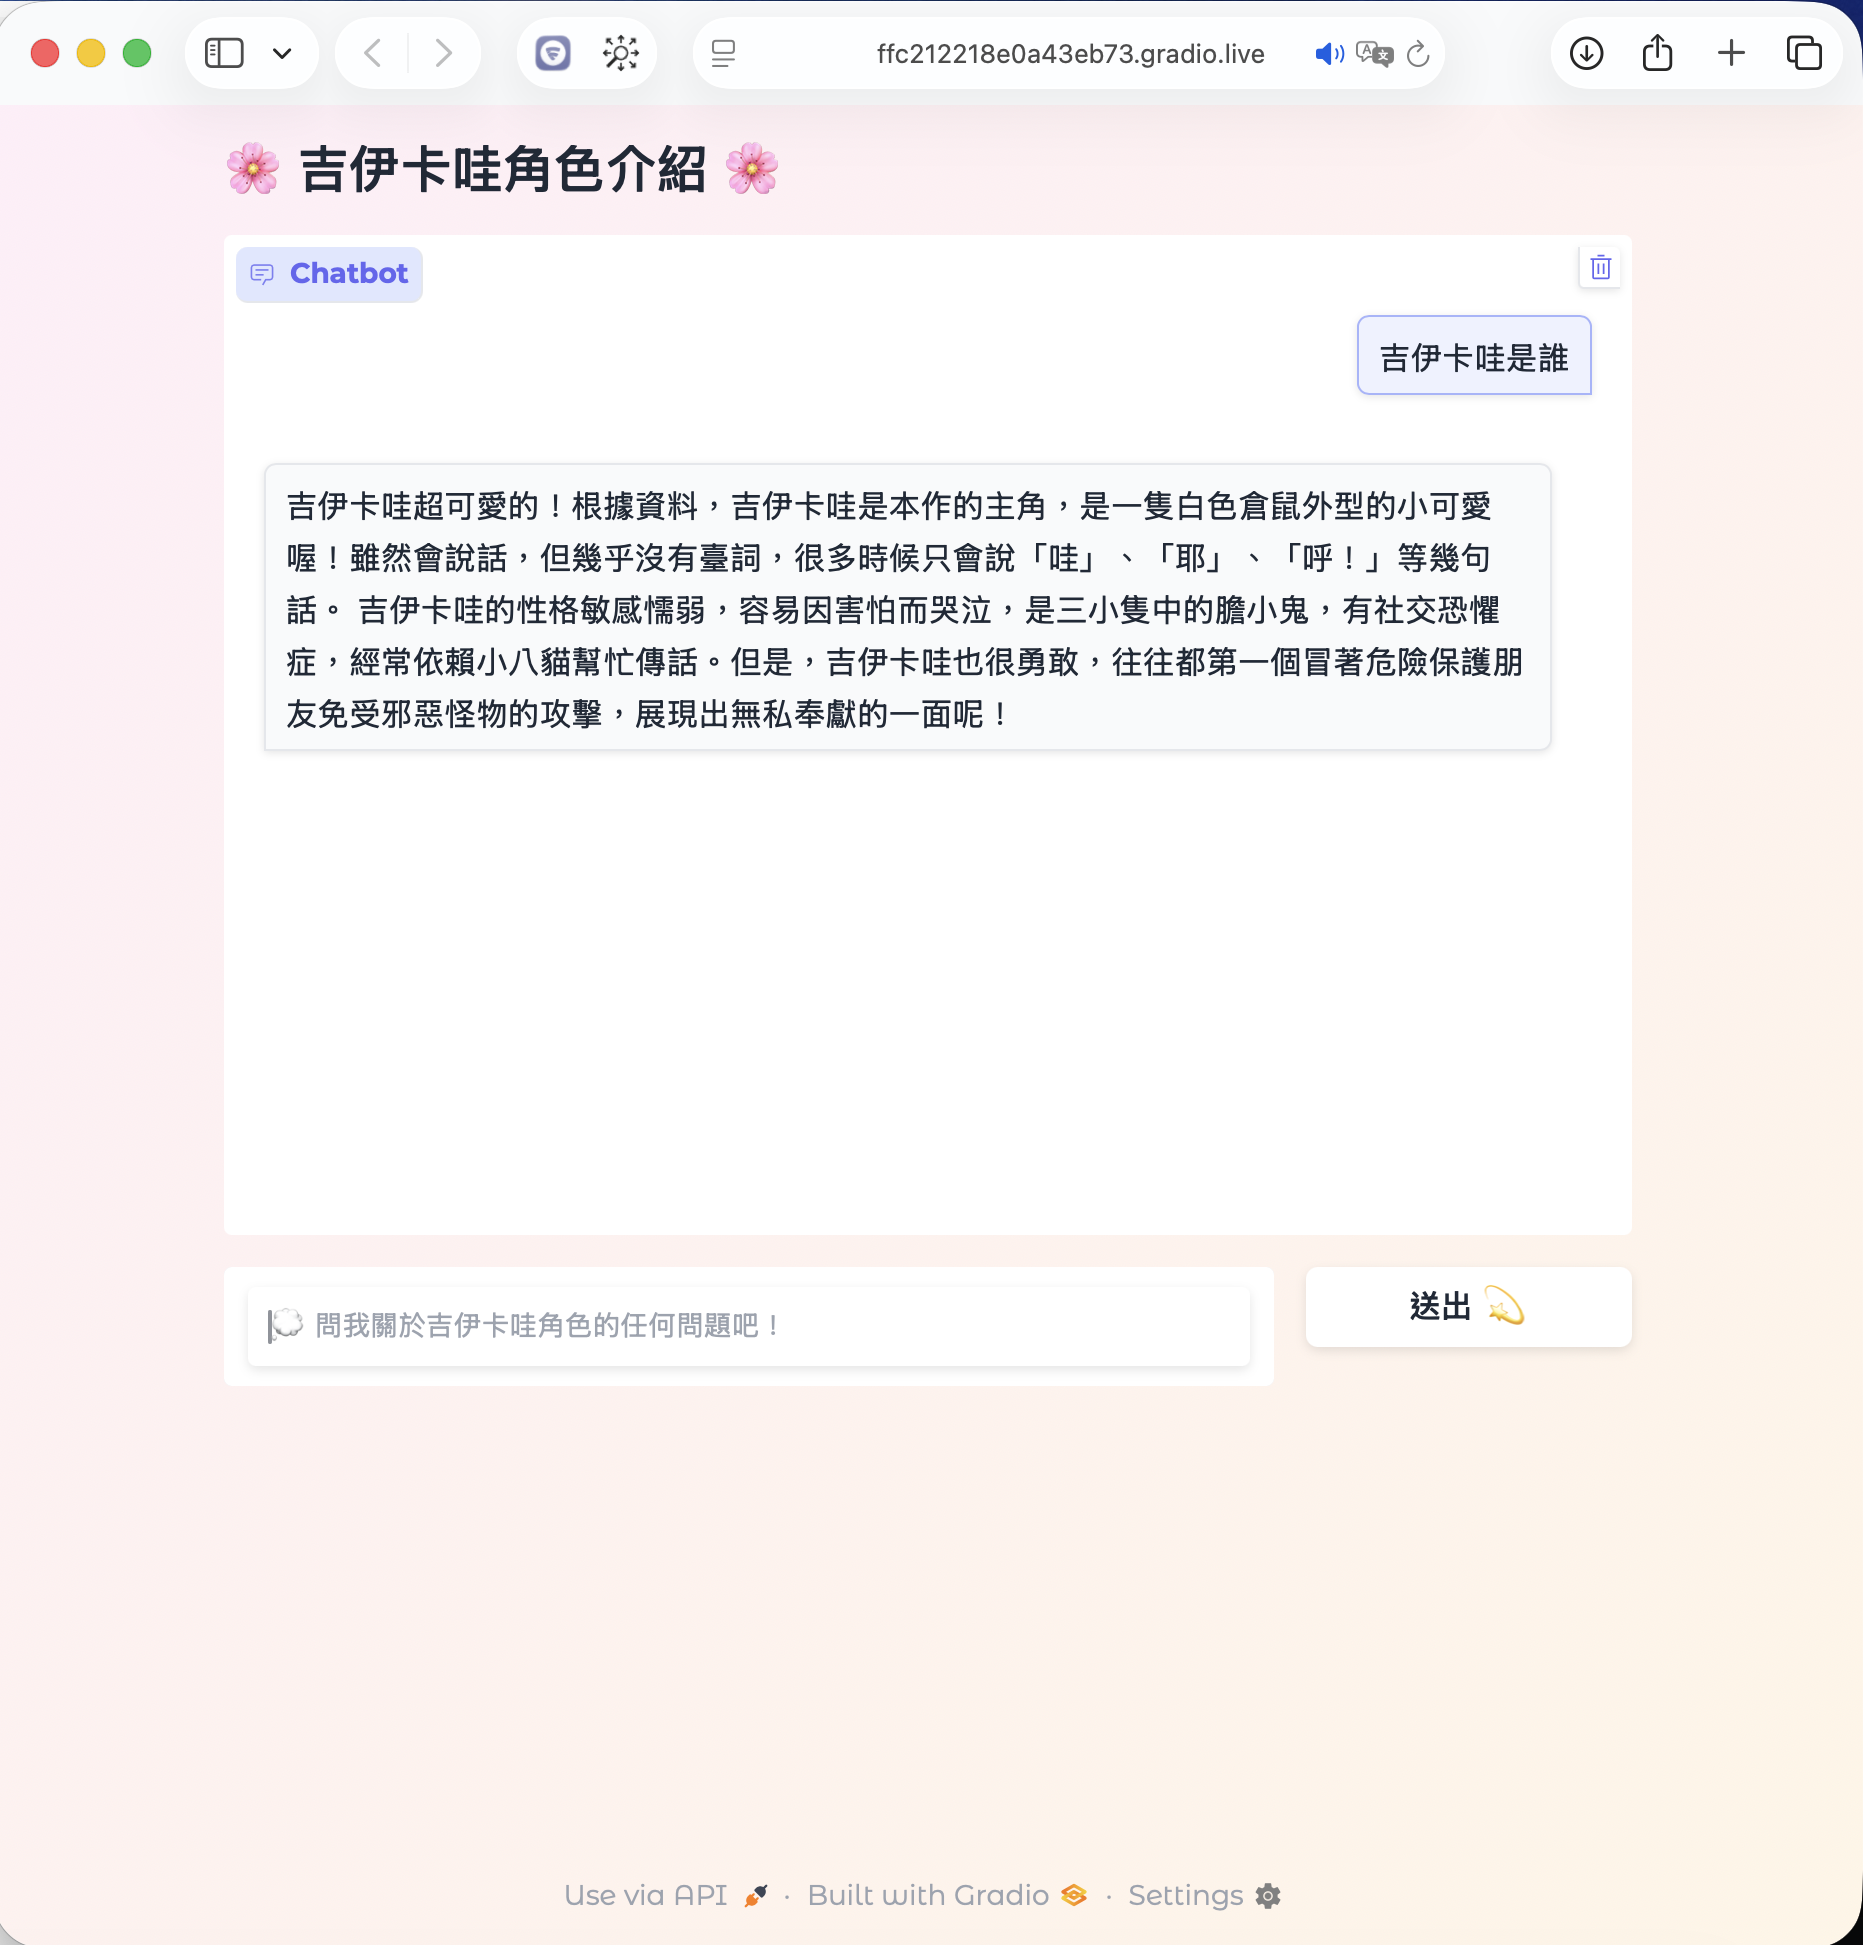